# Data analysis

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path
import sys

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. Descriptive statistics

### 1.1. Referrals

### 1.2. HIU

### 1.3. SNAP EDA

## 2. Exhaustiveness analysis of referrals

### 2.1. Data prep

In [3]:
from src.analysis_helpers import (
    load_and_merge_structured_and_predictions,
    create_exhaustiveness_long_format,
    summarize_exhaustiveness
)

In [4]:
hiu_structured_path =  "../data/processed/brc-cleaned/hiu_final.csv"
hiu_predictions_path = "../results/inference/hiu_final__Llama-3.1-8B-Instruct_bs8_lr9e-05_epochs6_20250710_164937_predictions/predictions.csv"

hiu_mapping = {
    "housing_need": "housing",
    "finances_need": "finances",
    "loneliness_need": "loneliness"
}

df_hiu = load_and_merge_structured_and_predictions(
    structured_path=hiu_structured_path,
    predictions_path=hiu_predictions_path
)

df_hiu_long = create_exhaustiveness_long_format(
    df_merged=df_hiu,
    structured_to_label=hiu_mapping
)

df_hiu_summary = summarize_exhaustiveness(df_hiu_long)

print("=== HIU Dataset: SDoH Exhaustiveness Summary ===")
display(df_hiu_summary)

=== HIU Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Experienced and documented in referral,Experienced but not documented in referral,Neither experienced nor documented in referral,Not experienced but documented in referral
sdoh_category,,,,
finances,56,249,713,70
housing,122,247,650,69
loneliness,243,581,194,70


In [5]:
snap_structured_path = "../data/processed/brc-cleaned/snap_final.csv"
snap_predictions_path = "../results/inference/snap_final__Llama-3.1-8B-Instruct_bs8_lr9e-05_epochs6_20250710_164937_predictions/predictions.csv"

snap_mapping = {
    "housing_need": "housing",
    "loneliness_need": "loneliness",
    "finances_need": "finances",
    "food_insecurity_need": "foodaccess"
}

df_snap = load_and_merge_structured_and_predictions(
    structured_path=snap_structured_path,
    predictions_path=snap_predictions_path
)

df_snap_long = create_exhaustiveness_long_format(
    df_merged=df_snap,
    structured_to_label=snap_mapping
)

df_snap_summary = summarize_exhaustiveness(df_snap_long)

print("=== SNAP Dataset: SDoH Exhaustiveness Summary ===")
display(df_snap_summary)

=== SNAP Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Experienced and documented in referral,Experienced but not documented in referral,Neither experienced nor documented in referral,Not experienced but documented in referral
sdoh_category,,,,
finances,43,148,484,34
foodaccess,92,72,401,144
housing,54,124,458,73
loneliness,165,159,295,90


In [6]:
df_hiu_long["dataset"] = "HIU"
df_snap_long["dataset"] = "SNAP"
df_combined_long = pd.concat([df_hiu_long, df_snap_long])

In [7]:
df_combined_long.columns

Index(['case_ref', 'sdoh_category', 'structured_experienced',
       'free_text_documented', 'documentation_status', 'dataset'],
      dtype='object')

### 2.2. Initial visualisations

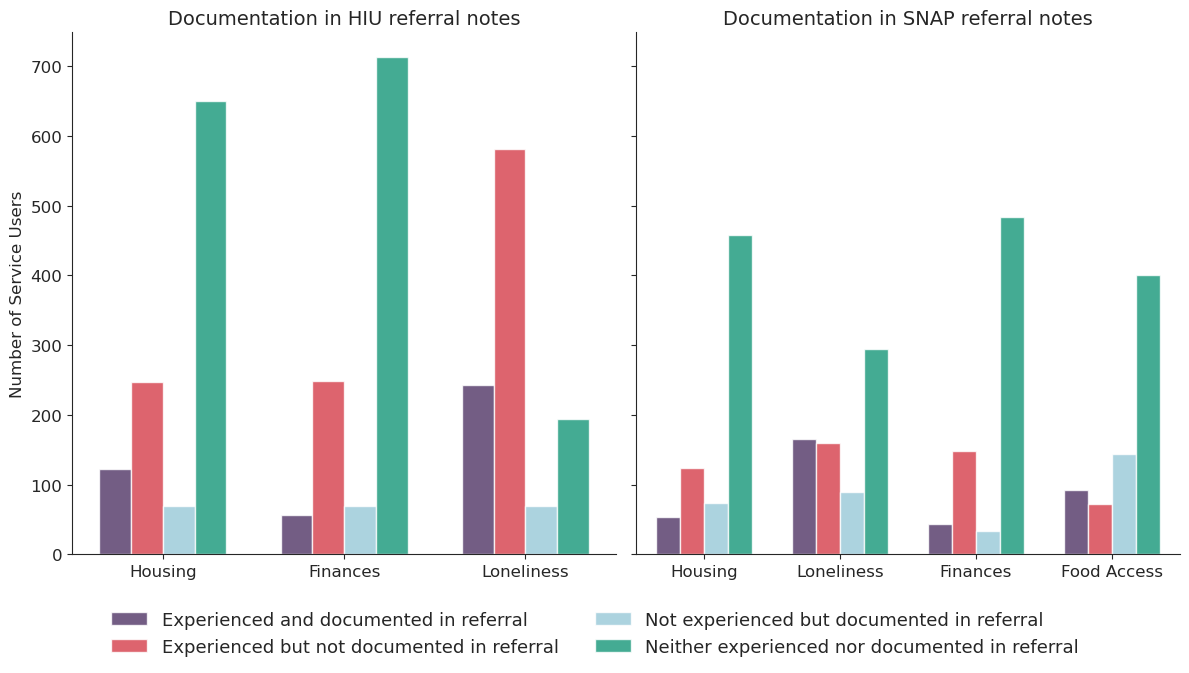

In [10]:
from src.analysis_helpers import plot_exhaustiveness_bar_faceted

plot_exhaustiveness_bar_faceted(df_combined_long)

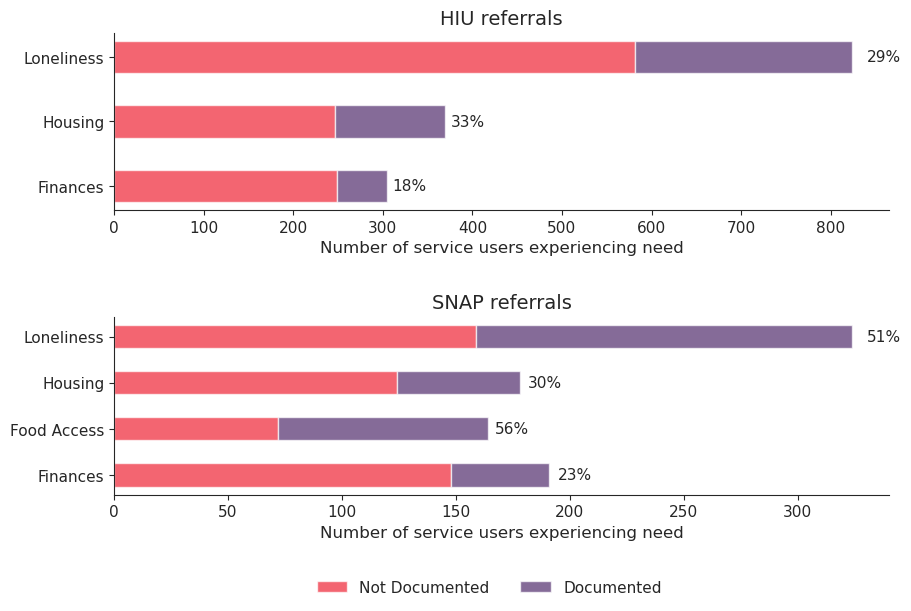

In [20]:
from src.analysis_helpers import plot_note_recall_stacked_bar

plot_note_recall_stacked_bar(df_combined_long)

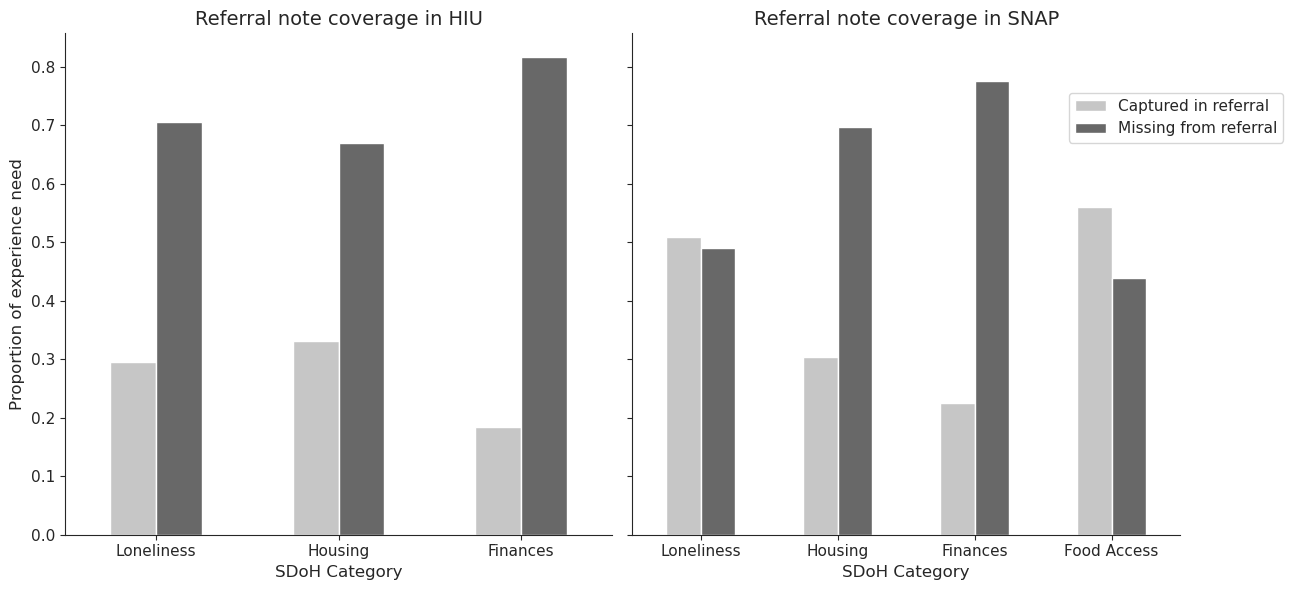

In [22]:
def plot_exhaustiveness_comparison_split(df_long, save_path="../results/figures/notes_exhaustiveness_comparison_split.png"):
    # Filter to experienced
    df_exp = df_long[df_long["structured_experienced"] == True].copy()
    df_exp = df_exp[~((df_exp["dataset"] == "HIU") & (df_exp["sdoh_category"] == "foodaccess"))]

    # Count proportions
    df_counts = df_exp.groupby(["dataset", "sdoh_category", "documentation_status"]).size().unstack(fill_value=0)
    df_counts["Total"] = df_counts.sum(axis=1)
    df_counts["Captured in referral"] = df_counts.get("Documented & Experienced", 0)
    df_counts["Missing from referral"] = df_counts.get("Undocumented but Experienced", 0)

    df_plot = df_counts[["Captured in referral", "Missing from referral"]].div(df_counts["Total"], axis=0)
    df_plot = df_plot.reset_index().melt(id_vars=["dataset", "sdoh_category"], var_name="Documentation", value_name="Proportion")

    # Relabel SDoH
    label_map = {
        "housing": "Housing",
        "finances": "Finances",
        "loneliness": "Loneliness",
        "foodaccess": "Food Access"
    }
    df_plot["sdoh_category"] = df_plot["sdoh_category"].map(label_map)
    category_order = ["Loneliness", "Housing", "Finances", "Food Access"]

    # Separate datasets
    datasets = df_plot["dataset"].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize=(12, 6), sharey=True)

    if len(datasets) == 1:
        axes = [axes]  # ensure iterable if single panel

    for i, dataset in enumerate(datasets):
        subset = df_plot[df_plot["dataset"] == dataset]
        order = subset["sdoh_category"].unique()

        sns.barplot(
            data=subset,
            x="sdoh_category",
            y="Proportion",
            hue="Documentation",
            palette="Greys",
            width=0.5,
            ax=axes[i],
            order=[c for c in category_order if c in subset["sdoh_category"].unique()]
        )

        axes[i].set_title(f"Referral note coverage in {dataset}", fontsize=14)
        axes[i].set_xlabel("SDoH Category", fontsize=12)
        axes[i].tick_params(axis="x", labelrotation=0, labelsize=11)
        axes[i].tick_params(axis="y", labelsize=11)
        if i == 0:
            axes[i].set_ylabel("Proportion of experience need", fontsize=12)
        else:
            axes[i].set_ylabel("")
        
        # Suppress duplicate legends
        axes[i].legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=None, loc="upper right", fontsize=11, bbox_to_anchor=(1.08, 0.85))
    sns.despine()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_exhaustiveness_comparison_split(df_combined_long)

### 2.3. Accounting for model uncertainty in SDoH documentation estimates
The proportion of Social Determinants of Health (SDoH) needs captured in referral notes is computed by comparing structured ground-truth needs to those detected by a fine-tuned language model. However, this estimate is influenced by the **performance of the model**—specifically, its **precision** and **recall**.

### 2.4. Exhaustiveness by referrer

In [8]:
# Load the referrals data
referrals_path = "../data/processed/brc-cleaned/referrals_cleaned.csv"
df_referrals = pd.read_csv(referrals_path)

# Drop any duplicate columns before merge (if any exist, e.g. case_ref)
df_referrals = df_referrals.loc[:, ~df_referrals.columns.duplicated()]

# Ensure 'case_ref' is string type to avoid mismatches
df_referrals["case_ref"] = df_referrals["case_ref"].astype(str)
df_combined_long["case_ref"] = df_combined_long["case_ref"].astype(str)

# Merge
df_merged = df_combined_long.merge(df_referrals, on="case_ref", how="left", suffixes=("", "_referral"))

In [9]:
df_referrals.columns

Index(['Area', 'Scheme', 'Case Reference', 'Assessment Result', 'Case Status',
       'Referral Date/Time', 'End Date Case', 'Has Disability', 'Has Risk',
       'Risk Type', 'Unique Case', 'IMD_decile', 'Country', 'Age', 'Gender',
       'Ethnicity', 'Disability', 'Living Arrangements',
       'Referral Notes (depersonalised)', 'case_ref', 'num_observations',
       'date_range_start', 'date_range_end', 'date_range_days',
       'referral_date'],
      dtype='object')

### 2.5. Exhautiveness by characteristics of the SU